# Jet Tagging with Deep Sets

This notebook shows how to use Deep Sets for jet classification between QCD and TT jets where we use cluster level information that we extract from the images. It is similar to the dataframes that you have been given, but instead we keep information from individual clusters. 

## What are Deep Sets?

Deep Sets are neural network architectures designed to process unordered sets. They learn representations that are permutation invariant, meaning the model’s output doesn’t depend on the order of inputs — ideal for point cloud-like data.

## Why use Deep Sets for Jet Tagging?
	•	Naturally handles jets as sets of particles
	•	Avoids information loss from image discretization
	•	Order-invariant: physics doesn’t depend on particle ordering
	•	Efficient and interpretable architecture for low-level inputs


## 1. Load and Prepare Data

If you've made it this far, you are ready for something more advanced. Instead of using simple dataloaders, we will now use the DataLoader class from Pytorch. This means we implement our own dataclass while inhereting useful features from torch's class. To see one of the many advantages, let's say you want to test a few different ways of processing your data. Instead of processing and then storing e.g. 10 slightly different datasets, you can process it on the fly, like we are doing here. 

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from utils.data_loading import get_dataloaders
from utils.plotting import plot_confusion_matrix, plot_training_history, plot_roc_curve

In [2]:
# Set data path and parameters
batch_size = 32
R = 0.4  # Jet radius parameter
pt_min = 0.1  # Minimum pT threshold

# Get dataloaders
train_loader, val_loader, test_loader = get_dataloaders(
    batch_size=batch_size,
    R=R,
    pt_min=pt_min
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 110
Number of validation batches: 16
Number of test batches: 32


# 2. Build deep set model

The current implementation is a basic version of the Deep Sets architecture from the paper "Deep Sets" by Zaheer et al. (2017). The key idea is that it's permutation invariant and can handle sets of variable size. The architecture consists of:
A φ network that processes each element (cluster in our case)
A pooling operation (mean in our case)
A ρ network that processes the pooled representation

In [3]:
class DeepSets(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super(DeepSets, self).__init__()
        self.phi = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.rho = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, x):
        # x shape: [batch_size, max_clusters, input_dim]
        
        # Apply phi network to each cluster
        phi_output = self.phi(x)  # [batch_size, max_clusters, hidden_dim]
        
        # Mean pooling over clusters
        pooled = phi_output.mean(dim=1)  # [batch_size, hidden_dim]
        
        # Apply rho network
        output = self.rho(pooled)  # [batch_size, 1]
        
        return output.squeeze(-1)  # [batch_size]

# 3. Train model 

In [4]:
# Initialize model and training components
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepSets().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

history = {
    'loss': [],
    'val_loss': [],
    'accuracy': [],
    'val_accuracy': []
}

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for clusters, labels in train_loader:
        clusters, labels = clusters.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(clusters)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Calculate accuracy
        preds = (outputs > 0).float()
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for clusters, labels in val_loader:
            clusters, labels = clusters.to(device), labels.to(device)
            outputs = model(clusters)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate accuracy
            preds = (outputs > 0).float()
            val_total += labels.size(0)
            val_correct += preds.eq(labels).sum().item()
    
    # Calculate epoch metrics
    train_loss /= len(train_loader)
    val_loss /= len(val_loader)
    train_acc = 100. * correct / total
    val_acc = 100. * val_correct / val_total
    
    # Append to history
    history['loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['accuracy'].append(train_acc)
    history['val_accuracy'].append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')



Epoch 1/10:
Train Loss: 0.5904, Train Acc: 68.89%
Val Loss: 0.4638, Val Acc: 77.69%
Epoch 2/10:
Train Loss: 0.4163, Train Acc: 81.48%
Val Loss: 0.3821, Val Acc: 82.87%
Epoch 3/10:
Train Loss: 0.3544, Train Acc: 85.60%
Val Loss: 0.3569, Val Acc: 86.65%
Epoch 4/10:
Train Loss: 0.3228, Train Acc: 87.16%
Val Loss: 0.3277, Val Acc: 86.06%
Epoch 5/10:
Train Loss: 0.3053, Train Acc: 88.24%
Val Loss: 0.3075, Val Acc: 88.25%
Epoch 6/10:
Train Loss: 0.2893, Train Acc: 89.06%
Val Loss: 0.2890, Val Acc: 87.25%
Epoch 7/10:
Train Loss: 0.2781, Train Acc: 89.18%
Val Loss: 0.2884, Val Acc: 87.65%
Epoch 8/10:
Train Loss: 0.2733, Train Acc: 89.80%
Val Loss: 0.2801, Val Acc: 87.65%
Epoch 9/10:
Train Loss: 0.2705, Train Acc: 89.66%
Val Loss: 0.3050, Val Acc: 85.06%
Epoch 10/10:
Train Loss: 0.2712, Train Acc: 89.43%
Val Loss: 0.2737, Val Acc: 88.05%


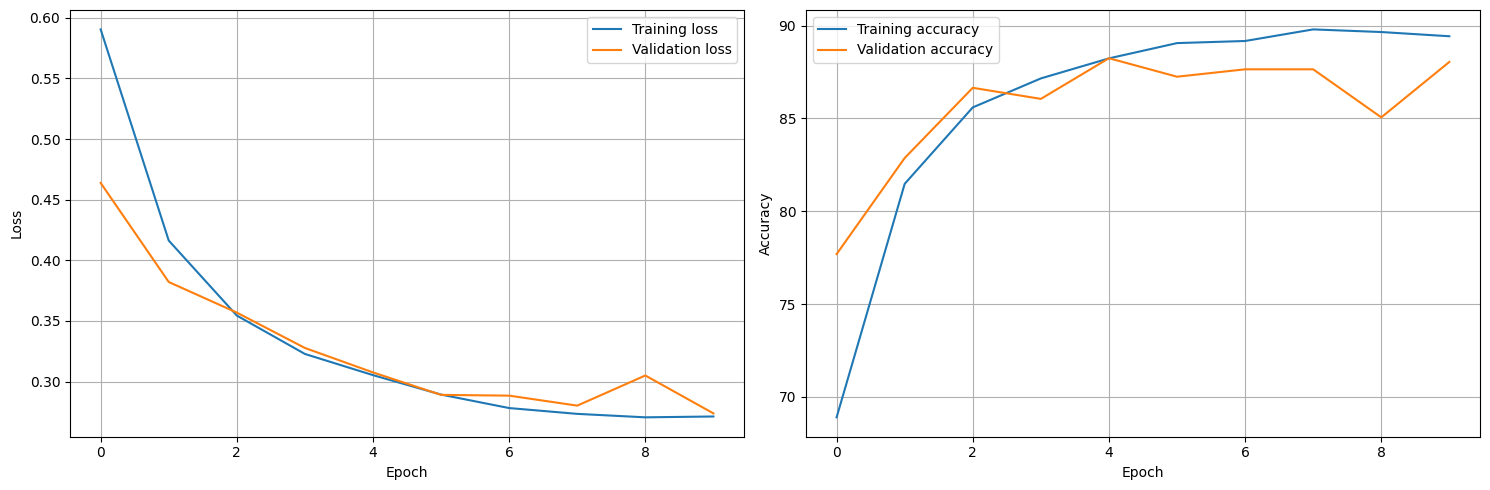

In [5]:
# Plot training history
plot_training_history(history, metrics=['loss', 'accuracy'])


# 4 - Evaluate model

Test Accuracy: 0.8805


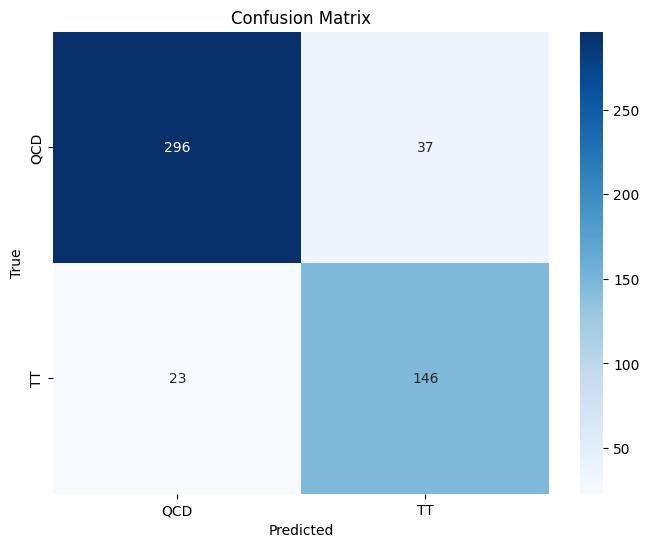

In [6]:
# Load best model and evaluate on test set
# model.load_state_dict(torch.load('best_model.pt'))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for clusters, labels in val_loader:  # Changed 'masks' to 'mask' to match dataset output
        clusters, labels = clusters.to(device), labels.to(device)  # Move mask to device too
        outputs = torch.sigmoid(model(clusters))  # Pass both clusters and mask to model
        
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds_discrete = np.where(np.array(all_preds) > 0.5, 1, 0)
# Calculate accuracy
accuracy = np.mean(np.array(all_preds_discrete) == np.array(all_labels))
print(f'Test Accuracy: {accuracy:.4f}')

# Plot confusion matrix
plot_confusion_matrix(all_labels, all_preds_discrete)

A lot of these models seem to end up at almost the exact same ROC score. Why do you think that is? 

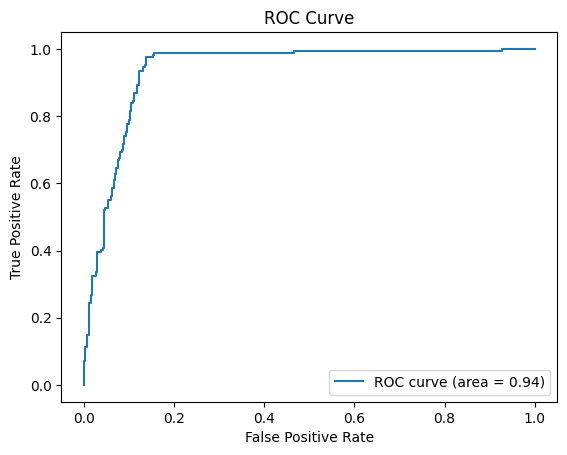

In [7]:
plot_roc_curve(all_labels, all_preds)

# 5 - Making predictions

In [8]:
y_pred_test = []
for data in test_loader:
    data = data[0]
    with torch.no_grad():
        output = model(data.to(device))
        # could you change the prediction threshold? Would that make it better?
        prediction = torch.sigmoid(output)
        y_pred_test.extend(prediction.to('cpu').numpy())

In [9]:
# import pandas as pd
# solution = pd.DataFrame({'id':test_ids, 'label':y_pred_test})
# solution.to_csv('solution.csv', index=False)